In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from dataloader import Dataset_from_pkl, is_filled
from model import LSTMTagger, LSTM_hid, LSTM_simple, OneLayer, LSTM_single, LSTM_single_with_emb
torch.manual_seed(1)
from tqdm import tqdm



## training on poses
1.37 lstm_tag 
<br>
1.19 lstm_hid
<br>
2.01   lstm_simple
<br>
2.1   OneLayer
<br>
1.8 lstm_single 


In [2]:

def get_observation_other_gt_poses(local_batch, poses=True):
    """
    for each agent in scene generate obseravtion, other_pose, future_poses
    observations -> list[tensors of shape [1,1,20,2]]]
    others -> list[tensors of shape [1,num_others,20,2]]]
    future_poses -> list[tensors of shape [1,1,12,2]]]
    """

    obseravtions = []
    gts = []
    others = []
    
    for ped in range(local_batch.shape[1]):
        observed_pose = local_batch[:, ped, :,2:4]
        obseravtions.append(observed_pose)
        gt_future = local_batch[:, ped:ped+1, 8:, 2:4]
        gts.append(gt_future)
        others_poses = torch.cat((local_batch[:, 0:ped, :, 2:4], local_batch[:, ped+1:, :,2:4]),dim=1)
        others.append(others_poses)

    return obseravtions, gts, others



In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_traj(data):
    #data shape [n, 2]
    x_poses = np.zeros((data.shape[0], data.shape[1]))
    y_poses = np.zeros((data.shape[0], data.shape[1]))
    for person in range(data.shape[0]):
        x_poses[person]  = data[person, :, 0].numpy()
        y_poses[person]  = data[person, :, 1].numpy()
    
    for person in range(data.shape[0]):
        plt.plot(x_poses[person], y_poses[person], 'o-')
    plt.show()

In [5]:
training_set = Dataset_from_pkl("/home/robot/repos/trajectories_pred/processed/", data_files=["eth_train.pkl"])
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print (device)
model  = LSTM_hid(10, 2, 2).to(device)
# model  = LSTM_simple(10, 2, 2).to(device)
# model  = OneLayer().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
drop_every_epochs = 5
drop_rate = 0.4
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, drop_every_epochs, drop_rate) # every drop_every_epochs epochs drop by drop_rate lr

loading eth_train.pkl
cuda


### training in separated manner

In [20]:
import time

for epoch in range(0,61):
    epoch_loss = 0
    start = time.time()
    for batch_id, local_batch in enumerate(training_generator):
        if batch_id>100:
            break
        obseravtions, gts, others = get_observation_other_gt_poses(local_batch.to(device))
        batch_loss = 0
        for observation, gt, other in zip(obseravtions, gts, others):
            model.zero_grad()
            fil = is_filled(observation)
            if fil:
                predictions = torch.zeros(1, 1, 0, 2).requires_grad_(True).to(device)
                for timestamp in range(0, 12):
                    
                    prediction = model(observation[:, 0+timestamp:8+timestamp, :], other[:, :, 0+timestamp:8+timestamp, :])
                    predictions = torch.cat((predictions, prediction.unsqueeze(0)), dim=2)

                loss = torch.sum(torch.norm(predictions - gt))
                batch_loss += loss.item()
                loss.backward()
                optimizer.step()
        if len(obseravtions) != 0:
#             print("\tid: {id}, batch_loss: {batch_loss:.2f}".format(batch_loss=batch_loss/len(obseravtions), id=id))
            epoch_loss += batch_loss/len(obseravtions)
        
    print ("epoch {epoch} loss {el:0.4f}, time taken {t:0.2f}".format(epoch=epoch, el=epoch_loss/batch_id,t=time.time()-start) )
    scheduler.step()


epoch 0 loss 2.9210, time taken 21.61
epoch 1 loss 2.1632, time taken 21.43
epoch 2 loss 2.0651, time taken 21.44
epoch 3 loss 1.9566, time taken 22.36
epoch 4 loss 1.8558, time taken 22.20
epoch 5 loss 1.7734, time taken 21.67
epoch 6 loss 1.7020, time taken 22.72
epoch 7 loss 1.6016, time taken 21.44
epoch 8 loss 1.5318, time taken 21.40
epoch 9 loss 1.4428, time taken 21.39
epoch 10 loss 1.4866, time taken 21.40
epoch 11 loss 1.4427, time taken 21.49
epoch 12 loss 1.4014, time taken 21.43
epoch 13 loss 1.3817, time taken 21.58
epoch 14 loss 1.3678, time taken 21.60
epoch 15 loss 1.3693, time taken 21.61
epoch 16 loss 1.3514, time taken 21.81
epoch 17 loss 1.3397, time taken 21.53
epoch 18 loss 1.3302, time taken 21.44
epoch 19 loss 1.3227, time taken 21.52
epoch 20 loss 1.3254, time taken 21.50
epoch 21 loss 1.3185, time taken 21.62
epoch 22 loss 1.3150, time taken 21.75
epoch 23 loss 1.3103, time taken 22.34
epoch 24 loss 1.3084, time taken 22.44
epoch 25 loss 1.3075, time taken 22

## Parallel manner

###  single - 1.83
###  single with emb- 1.94

In [2]:
training_set = Dataset_from_pkl("/home/robot/repos/trajectories_pred/processed/", data_files=["eth_train.pkl"])
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print (device)
# model  = LSTM_single(20, 2, 2).to(device)
# model  = LSTM_simple(10, 2, 2).to(device)
# model  = OneLayer().to(device)
model = LSTM_single_with_emb(40, 20, 2).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
drop_every_epochs = 5
drop_rate = 0.4
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, drop_every_epochs, drop_rate) # every drop_every_epochs epochs drop by drop_rate lr

loading eth_train.pkl
cuda


In [3]:
import time

for epoch in range(0,61):
    epoch_loss = 0
    start = time.time()
    epoch_loss = 0
    for batch_id, local_batch in enumerate(training_generator):
        if batch_id>100:
            break
        local_batch = local_batch.to(device)
        model.zero_grad()
        num_peds = local_batch.shape[1]
        predictions = torch.zeros(num_peds, 0, 2).requires_grad_(True).to(device)
        for t in range(0,12):
            prediction = model(local_batch[0,:,0+t:8+t,2:4])
            predictions = torch.cat((predictions, prediction), dim=1)
        
        loss  = torch.sum(torch.norm(predictions - local_batch[0,:,8:,2:4]))
        epoch_loss += loss.item()/num_peds
        loss.backward()
        optimizer.step()
    print ("epoch {epoch} loss {el:0.4f}, time taken {t:0.2f}".format(epoch=epoch, el=epoch_loss/batch_id,t=time.time()-start) )
    scheduler.step()

epoch 0 loss 4.3846, time taken 1.90
epoch 1 loss 3.7220, time taken 1.95
epoch 2 loss 3.6520, time taken 1.90
epoch 3 loss 3.6089, time taken 1.95
epoch 4 loss 3.8409, time taken 1.91
epoch 5 loss 3.8633, time taken 1.99
epoch 6 loss 4.0251, time taken 1.89
epoch 7 loss 3.8558, time taken 1.88
epoch 8 loss 3.8689, time taken 1.90
epoch 9 loss 3.7131, time taken 1.97
epoch 10 loss 3.6113, time taken 1.93
epoch 11 loss 3.5277, time taken 1.99
epoch 12 loss 3.4830, time taken 1.90
epoch 13 loss 3.4018, time taken 1.87
epoch 14 loss 3.3956, time taken 1.89
epoch 15 loss 3.3342, time taken 1.90
epoch 16 loss 3.3024, time taken 1.91
epoch 17 loss 3.2884, time taken 1.90
epoch 18 loss 3.2768, time taken 1.89
epoch 19 loss 3.2633, time taken 1.90
epoch 20 loss 3.2383, time taken 1.91
epoch 21 loss 3.2269, time taken 1.90
epoch 22 loss 3.2206, time taken 1.89
epoch 23 loss 3.2154, time taken 1.89
epoch 24 loss 3.2107, time taken 1.90
epoch 25 loss 3.1994, time taken 1.92
epoch 26 loss 3.1966, 

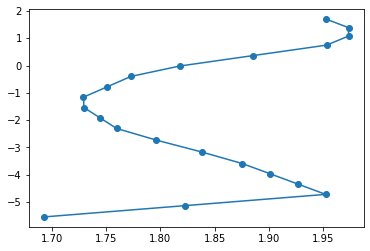

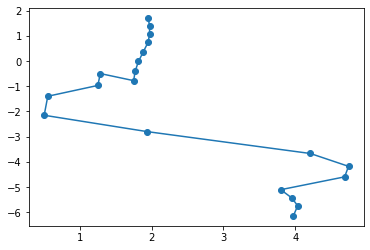

In [56]:
for batch_id, local_batch in enumerate(training_generator):
    if batch_id != 460:
        continue
    obseravtions, gts, others = get_observation_other_gt_poses(local_batch.to(device))
    for observation, gt, other in zip(obseravtions, gts, others):
        predictions = torch.zeros(1, 1, 0, 2).requires_grad_(True).to(device)
        for timestamp in range(0, 12):
            prediction = model(observation[:, 0+timestamp:8+timestamp, :].clone(), other[:, :, 0+timestamp:8+timestamp, :].clone())
            predictions = torch.cat((predictions, prediction.unsqueeze(0)), dim=2)
        break
    break
pass


data = obseravtions[0][:,:,:].detach().cpu()


plot_traj(data)
data = obseravtions[0][:,0:8,:].detach().cpu()

data = torch.cat((data, predictions[0].detach().cpu()), dim=1)
plot_traj(data)


In [20]:
t = torch.rand(1,10,20,8)
ind = 6
t1 = t[:,0:ind,:,:]
t2 = t[:,ind+1:,:,:]
print (t1.shape, t2.shape)
torch.cat((t1,t2),dim=1).shape


torch.Size([1, 6, 20, 8]) torch.Size([1, 3, 20, 8])


torch.Size([1, 9, 20, 8])